## Compute the step function, the integral, and the autoconvolution

In [1]:
import torch
import torch.nn.functional as F

# Step function representation:
# The step function f is implicitly defined by:
# - heights: a 1D tensor of P non-negative values h_i.
# - P: number of pieces.
# - interval_range: a tuple (x_min, x_max), e.g., (-0.25, 0.25).
# - delta_x: width of each piece, (x_max - x_min) / P.
# - x_coords: tensor of starting x-coordinates for each piece.
# For optimization, 'heights' would be your learnable parameters.
#
# Example of how you might define these:
# P = 600
# interval_range = (-0.25, 0.25)
# heights = torch.rand(P, dtype=torch.float64, requires_grad=True) # example heights
# delta_x = (interval_range[1] - interval_range[0]) / P
# x_min = interval_range[0]

def compute_integral_of_step_function(heights: torch.Tensor, delta_x: float) -> torch.Tensor:
    """
    Computes the integral of the step function f(x)dx.
    f(x) is defined by `heights` h_i over pieces of width `delta_x`.
    Integral = delta_x * sum(h_i).
    """
    if not torch.all(heights >= 0):
        # print("warning: heights should be non-negative for the problem context.")
        # depending on your optimization strategy, you might enforce this elsewhere (e.g. h_i = relu(alpha_i))
        pass # up to you how strict to be here, problem says "non-negative f"
    return delta_x * torch.sum(heights)

def compute_autoconvolution_values(heights: torch.Tensor, delta_x: float, P: int) -> torch.Tensor:
    """
    Computes the values of the autoconvolution (f*f)(t) at the knot points.
    (f*f)(t) is piecewise linear. Max value occurs at one of these knots.
    Knots are t_m = 2*x_min + m*delta_x for m = 0, ..., 2P.
    Values are [0, delta_x * (H*H)_0, ..., delta_x * (H*H)_{2P-2}, 0].
    (H*H) is the discrete convolution of the height sequence H.
    """
    # Ensure heights is 1D
    if heights.ndim != 1 or heights.shape[0] != P:
        raise ValueError(f"heights tensor must be 1D with length P={P}. Got shape {heights.shape}")

    # Reshape heights for conv1d: (batch_size, C_in, L_in)
    # batch_size=1, C_in=1
    h_signal = heights.view(1, 1, P)
    
    # The kernel for conv1d to compute (H*H) should be H flipped.
    # weight for conv1d: (C_out, C_in/groups, L_kernel)
    # C_out=1, C_in/groups=1
    h_kernel_flipped = torch.flip(heights, dims=[0]).view(1, 1, P)

    # Compute H*H using conv1d. Padding P-1 results in output length 2P-1.
    # These are (H*H)_0, ..., (H*H)_{2P-2}
    conv_result = F.conv1d(h_signal, h_kernel_flipped, padding=P-1).squeeze()
    
    # Scale by delta_x
    conv_scaled = delta_x * conv_result
    
    # Add zeros for (f*f)(t_0) and (f*f)(t_{2P})
    zero = torch.tensor([0.0], device=heights.device, dtype=heights.dtype)
    autoconvolution_knot_values = torch.cat([zero, conv_scaled, zero])
    
    return autoconvolution_knot_values


## Plot the step function and the autoconvolution

--- Function Details (P=600) ---
Integral of f(x): 0.245511
Max value of autoconvolution (f*f)(t): 0.122913
Ratio max(f*f) / (integral(f))^2: 2.039187


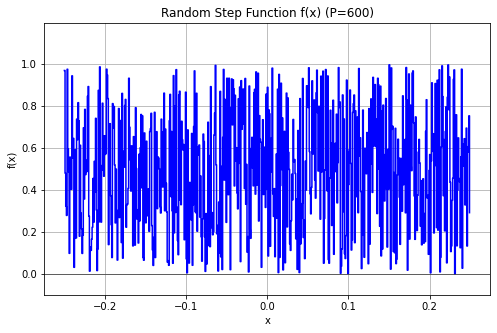

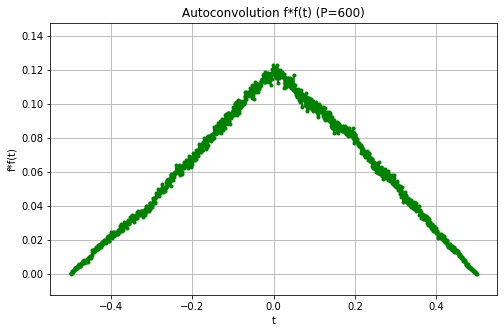

In [10]:
# script assumes 'compute_integral_of_step_function' and 'compute_autoconvolution_values'
# (from your previous code block) are already defined and executable in the notebook.

#@title Imports and Plotting Setup
import torch
import numpy as np
import matplotlib.pyplot as plt

# --- plotting functions ---
def plot_rendered_step_function(heights_numpy: np.ndarray, interval: tuple[float, float], title=""):
    """plots a step function f(x) cleanly using plt.step."""
    P = len(heights_numpy)
    x_min, x_max = interval
    
    step_edges = np.linspace(x_min, x_max, P + 1, dtype=float) # ensure float for plotting
    
    plt.figure(figsize=(8, 5))
    plt.step(step_edges[:-1], heights_numpy, where='post', color='blue', linewidth=1.5)
    
    plt.axhline(0, color='black', linewidth=0.5) # reference line at y=0
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.title(title)
    
    # dynamic axis limits
    x_padding = 0.05 * (x_max - x_min) if (x_max - x_min) > 0 else 0.05
    plt.xlim([x_min - x_padding, x_max + x_padding])
    
    if P > 0:
        max_h = np.max(heights_numpy)
        min_h = np.min(heights_numpy) # relevant if heights could be negative
        if max_h > 0: # typical case for non-negative heights
            plt.ylim([-0.1 * max_h, max_h * 1.2])
        elif max_h == 0 and min_h == 0 : # all zero heights
            plt.ylim([-0.5, 0.5])
        else: # other cases (e.g. all negative, not expected here)
            plt.ylim([min_h - 0.1*abs(min_h), max_h + 0.1*abs(max_h)])

    else: # P=0, no data
        plt.ylim([-0.5, 1.0]) 
        
    plt.grid(True)
    plt.show()

def plot_rendered_convolution(t_values_numpy: np.ndarray, conv_values_numpy: np.ndarray, title=""):
    """plots a piecewise linear function, e.g., the autoconvolution f*f(t)."""
    plt.figure(figsize=(8, 5))
    plt.plot(t_values_numpy, conv_values_numpy, marker='o', linestyle='-', color='green', markersize=3, linewidth=1.5)
    
    plt.xlabel("t")
    plt.ylabel("f*f(t)")
    plt.title(title)
    
    if len(t_values_numpy) > 0:
        t_min, t_max = t_values_numpy[0], t_values_numpy[-1]
        t_padding = 0.05 * (t_max - t_min) if (t_max - t_min) > 0 else 0.05
        plt.xlim([t_min - t_padding, t_max + t_padding])
        
        max_conv = np.max(conv_values_numpy)
        min_conv = np.min(conv_values_numpy)
        # autoconvolution of non-negative f(x) is non-negative
        if max_conv > 0:
            plt.ylim([-0.1 * max_conv, max_conv * 1.2])
        else: # all zero (or P=0 for f(x))
            plt.ylim([-0.5, 0.5])
    else: # no data
        plt.xlim([-0.55, 0.55]) # default based on expected autoconv range
        plt.ylim([-0.1, 1.0])
        
    plt.grid(True)
    plt.show()

# --- main script logic ---
P_val = 600  # number of pieces for the step function
f_interval = (-0.25, 0.25) # interval for f(x)

f_x_min, f_x_max = f_interval
f_delta_x = (f_x_max - f_x_min) / P_val

# 1. sample random heights (non-negative)
# using float64 for precision, requires_grad=False for plotting/evaluation only
height_values = torch.rand(P_val, dtype=torch.float64) 
# for more structured/sparse functions, you could try:
# height_values = torch.abs(torch.randn(P_val, dtype=torch.float64)) * (torch.rand(P_val, dtype=torch.float64) > 0.7).double()


# 2. compute integral of f(x)
integral_value = compute_integral_of_step_function(height_values, f_delta_x)

# 3. compute autoconvolution (f*f)(t) knot values
# (2*P_val + 1) values for t_m from 2*f_x_min to 2*f_x_max
autoconv_knot_vals = compute_autoconvolution_values(height_values, f_delta_x, P_val)
max_autoconv_value = torch.max(autoconv_knot_vals)

# 4. calculate the ratio for C1 estimate
# (max f*f(t)) / (integral f(x) dx)^2
if integral_value.item() == 0:
    c1_ratio = float('inf') if max_autoconv_value.item() > 0 else 0.0 # handle division by zero
else:
    c1_ratio = max_autoconv_value / (integral_value**2)

print(f"--- Function Details (P={P_val}) ---")
# print(f"Heights (h_i, first 10): {height_values.numpy()[:10]}") # uncomment if you want to see heights
print(f"Integral of f(x): {integral_value.item():.6f}")
print(f"Max value of autoconvolution (f*f)(t): {max_autoconv_value.item():.6f}")
print(f"Ratio max(f*f) / (integral(f))^2: {c1_ratio.item():.6f}")


# 5. plotting
# plot f(x)
plot_rendered_step_function(height_values.numpy(), f_interval, title=f"Random Step Function f(x) (P={P_val})")

# plot f*f(t)
# autoconvolution is defined on [2*f_x_min, 2*f_x_max]
conv_t_knots = np.linspace(2 * f_x_min, 2 * f_x_max, 2 * P_val + 1, dtype=float)
plot_rendered_convolution(conv_t_knots, autoconv_knot_vals.numpy(), title=f"Autoconvolution f*f(t) (P={P_val})")

## Projection onto the simplex

In [18]:
import torch

def projection_simplex_pytorch(v: torch.Tensor, z: float = 1.0) -> torch.Tensor:
    n_features = v.shape[0]
    if n_features == 0:
        return torch.empty_like(v)
    u, _ = torch.sort(v, descending=True)
    cssv_minus_z = torch.cumsum(u, dim=0) - z
    ind = torch.arange(1, n_features + 1, device=v.device) 
    cond = u - cssv_minus_z / ind > 0
    true_indices = torch.where(cond)[0]
    rho_idx = true_indices[-1] 
    rho = ind[rho_idx] 
    theta = cssv_minus_z[rho_idx] / rho 
    w = torch.clamp(v - theta, min=0.0)
    return w

# test the function
v = torch.tensor([1.0, 2.0, 3.0])
z = 100
w = projection_simplex_pytorch(v, z)
print("w", w, "sum(w)", sum(w))



w tensor([32.3333, 33.3333, 34.3333]) sum(w) tensor(100.0000)


## Set up parameters, loss function, and compute the gradient

In [100]:
# Setting function parameters
P_val = 600  # number of pieces for the step function
f_interval = (-0.25, 0.25) # interval for f(x)

f_x_min, f_x_max = f_interval
f_delta_x = (f_x_max - f_x_min) / P_val

# Define optimization variable
height_params = torch.rand(P_val, dtype=torch.float64)
height_params.requires_grad = True

def loss_fn(): 
    max_f_conv_f_values_at_knots = compute_autoconvolution_values(height_params, f_delta_x, P_val)
    return max_f_conv_f_values_at_knots.max()

# Project variables onto the simplex 
with torch.no_grad():
    height_params.data = projection_simplex_pytorch(height_params.data, 2*P_val)

# Compute loss and gradient
height_params.grad = None
loss = loss_fn()
loss.backward()
print("loss", loss.item())

print("height_params.grad", height_params.grad)



loss 2.0038365431176195
height_params.grad tensor([0.0025, 0.0037, 0.0043, 0.0018, 0.0048, 0.0030, 0.0041, 0.0038, 0.0021,
        0.0032, 0.0046, 0.0028, 0.0026, 0.0028, 0.0034, 0.0045, 0.0027, 0.0033,
        0.0040, 0.0017, 0.0034, 0.0048, 0.0042, 0.0042, 0.0027, 0.0042, 0.0045,
        0.0036, 0.0035, 0.0044, 0.0022, 0.0031, 0.0039, 0.0037, 0.0044, 0.0039,
        0.0037, 0.0023, 0.0041, 0.0029, 0.0034, 0.0028, 0.0041, 0.0037, 0.0020,
        0.0017, 0.0050, 0.0040, 0.0026, 0.0024, 0.0046, 0.0041, 0.0037, 0.0035,
        0.0047, 0.0031, 0.0050, 0.0029, 0.0039, 0.0023, 0.0046, 0.0018, 0.0020,
        0.0027, 0.0031, 0.0031, 0.0038, 0.0032, 0.0020, 0.0027, 0.0025, 0.0047,
        0.0045, 0.0043, 0.0046, 0.0031, 0.0019, 0.0026, 0.0043, 0.0035, 0.0034,
        0.0039, 0.0020, 0.0035, 0.0022, 0.0035, 0.0023, 0.0032, 0.0046, 0.0017,
        0.0035, 0.0023, 0.0041, 0.0019, 0.0039, 0.0017, 0.0025, 0.0046, 0.0045,
        0.0042, 0.0017, 0.0044, 0.0030, 0.0037, 0.0042, 0.0036, 0.0041, 0.002

## Algorithm 1: (Projected) Polyak subgradient method

The algorithm 
$$
h_+ = \mathrm{proj}_{\Delta_{2P}}\left(h - \frac{L(h) - L^*}{\| \nabla L(h) \|^2} \nabla L(h)\right)
$$
where $L^*$ is the target loss.

Iteration 0: loss = 1.519450, step_size = 0.233750, min_loss_found = 1.519248
Iteration 100: loss = 1.519464, step_size = 0.168880, min_loss_found = 1.519248
Iteration 200: loss = 1.519440, step_size = 0.134518, min_loss_found = 1.519248
Iteration 300: loss = 1.519413, step_size = 0.138753, min_loss_found = 1.519248
Iteration 400: loss = 1.519546, step_size = 0.163531, min_loss_found = 1.519248
Iteration 500: loss = 1.519471, step_size = 0.207222, min_loss_found = 1.519248
Iteration 600: loss = 1.519530, step_size = 0.181352, min_loss_found = 1.519248
Iteration 700: loss = 1.519455, step_size = 0.160516, min_loss_found = 1.519248
Iteration 800: loss = 1.519378, step_size = 0.242725, min_loss_found = 1.519248
Iteration 900: loss = 1.519462, step_size = 0.171143, min_loss_found = 1.519248
Iteration 1000: loss = 1.519345, step_size = 0.200080, min_loss_found = 1.519248
Iteration 1100: loss = 1.519449, step_size = 0.151273, min_loss_found = 1.519248
Iteration 1200: loss = 1.519460, step_si

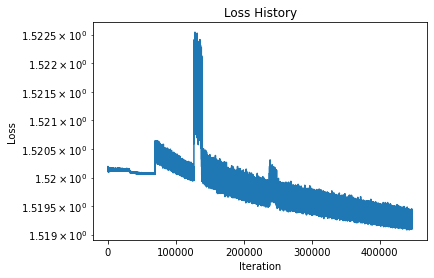

In [125]:
max_iter = 100000
# if loss history exists, append to it
if 'loss_history' not in locals():
    loss_history = []

target_loss = 1.5179
print_every = 100
if 'min_loss_found' not in locals():
    min_loss_found = float('inf')

if 'best_height_params' not in locals():
    best_height_params = height_params.data.clone()

for i in range(max_iter):
    # Compute loss and gradient
    height_params.grad = None
    loss = loss_fn()
    loss.backward()

    grad = height_params.grad.data
    grad_norm_squared = torch.norm(grad)**2
    
    step_size = (loss.item() - target_loss) / grad_norm_squared
    height_params.data -= step_size * (grad + torch.randn_like(grad) * 0.000)

    # Project onto the simplex
    with torch.no_grad():
        height_params.data = projection_simplex_pytorch(height_params.data, 2*P_val)

    loss_history.append(loss.item())        
    if i % print_every == 0:
        print(f"Iteration {i}: loss = {loss.item():.6f}, step_size = {step_size:.6f}, min_loss_found = {min_loss_found:.6f}",)

    if loss.item() < min_loss_found:
        min_loss_found = loss.item()
        best_height_params = height_params.data.clone()

print("Final loss:", loss.item())

# semilogy plot of loss history
plt.semilogy(loss_history)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss History")
plt.show()

